# House Price Regression with Neural Network

## 1. Import lib and set up enviroment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
## this is statistics lib
from scipy import stats

### Set up parameters

In [2]:
# setting the number of cross validations used in the Model part
nr_cv = 5

# switch for using log values for SalePrice and features
use_logvals = 1
# target used for correlation 
target = 'SalePrice_Log'

# only columns with correlation above this threshold value
# are used for the ML Regressors in Part 3
min_val_corr = 0.5
    
# switch for dropping columns that are similar to others already used and show a high correlation to these     
drop_similar = 1

### Useful function

In [3]:
# Haven't known yet
def get_best_score(grid):
    
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)    
    print(grid.best_params_)
    print(grid.best_estimator_)
    
    return best_score

In [4]:
# Return Columns with largest correlations
def print_cols_large_corr(df, nr_c, targ) :
    corr = df.corr()
    corr_abs = corr.abs()
    print (corr_abs.nlargest(nr_c, targ)[targ])

In [5]:
# Haven't known yet
def plot_corr_matrix(df, nr_c, targ) :
    
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()

### Load data

In [6]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## 2. Analysis

### Basic info about this df:

In [7]:
train.shape

(1460, 81)

In [8]:
test.shape

(1459, 80)

In [9]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
len(train.select_dtypes(include=['int', 'float']).dtypes.index)

38

In [11]:
train.select_dtypes(include=['int', 'float']).dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

In [12]:
len(train.select_dtypes(include=['object']).dtypes.index)

43

In [13]:
train.select_dtypes(include=['object']).dtypes

MSZoning         object
Street           object
Alley            object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
PoolQC           object
Fence            object
MiscFeature      object
SaleType        

### Target Feature: Sale Price

Skewness: 1.882876
Kurtosis: 6.536282


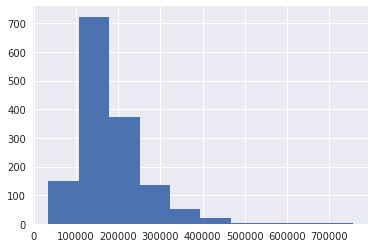

In [14]:
plt.hist(train['SalePrice']);
#skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

In [15]:
train['SalePrice_Log'] = np.log1p(train['SalePrice'])

Skewness: 0.121347
Kurtosis: 0.809519


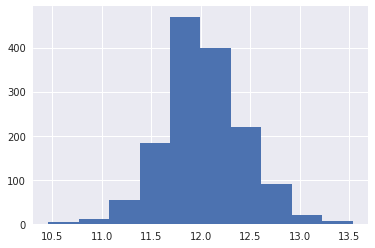

In [16]:
plt.hist(train['SalePrice_Log']);
#skewness and kurtosis
print("Skewness: %f" % train['SalePrice_Log'].skew())
print("Kurtosis: %f" % train['SalePrice_Log'].kurt())

In [17]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,SalePrice_Log
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890,12.024057
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883,0.399449
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000,10.460271
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000,11.775105
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000,12.001512
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000,12.273736
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000,13.534474


In [18]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePrice_Log
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,12.247699
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,12.109016
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,12.317171
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,11.849405
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,12.429220


In [19]:
train.drop('SalePrice', axis= 1, inplace=True)

In [20]:
numerical_feats = train.dtypes[train.dtypes != "object"].index
categorical_feats = train.dtypes[train.dtypes == "object"].index

In [21]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/1460).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


#### There is a lot of features with NaN but some of them means 'None' rather than 'NaN' (as mentioned in data description)

In [22]:
# columns where NaN values have meaning e.g. no pool etc.
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    train[col].fillna('None',inplace=True)
    test[col].fillna('None',inplace=True)

In [23]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/1460).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrArea,8,0.005479
SalePrice_Log,0,0.000000
ExterCond,0,0.000000
RoofStyle,0,0.000000
RoofMatl,0,0.000000
Exterior1st,0,0.000000
Exterior2nd,0,0.000000
MasVnrType,0,0.000000


In [24]:
train[['LotFrontage', 'GarageYrBlt', 'MasVnrArea']].head()

,LotFrontage,GarageYrBlt,MasVnrArea
0,65.0,2003.0,196.0
1,80.0,1976.0,0.0
2,68.0,2001.0,162.0
3,60.0,1998.0,0.0
4,84.0,2000.0,350.0


All of them is numerical

In [25]:
# fillna with mean or mode for the remaining values
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)
train.fillna(train.mode(), inplace=True)
test.fillna(test.mode(), inplace=True)

### Now we check for some bad distribution

for df in [train, test]:
    df['GrLivArea_Log'] = np.log(df['GrLivArea'])
    df.drop('GrLivArea', inplace= True, axis = 1)
    df['LotArea_Log'] = np.log(df['LotArea'])
    df.drop('LotArea', inplace= True, axis = 1)
    
    
    
numerical_feats = train.dtypes[train.dtypes != "object"].index

### Visualize data relation

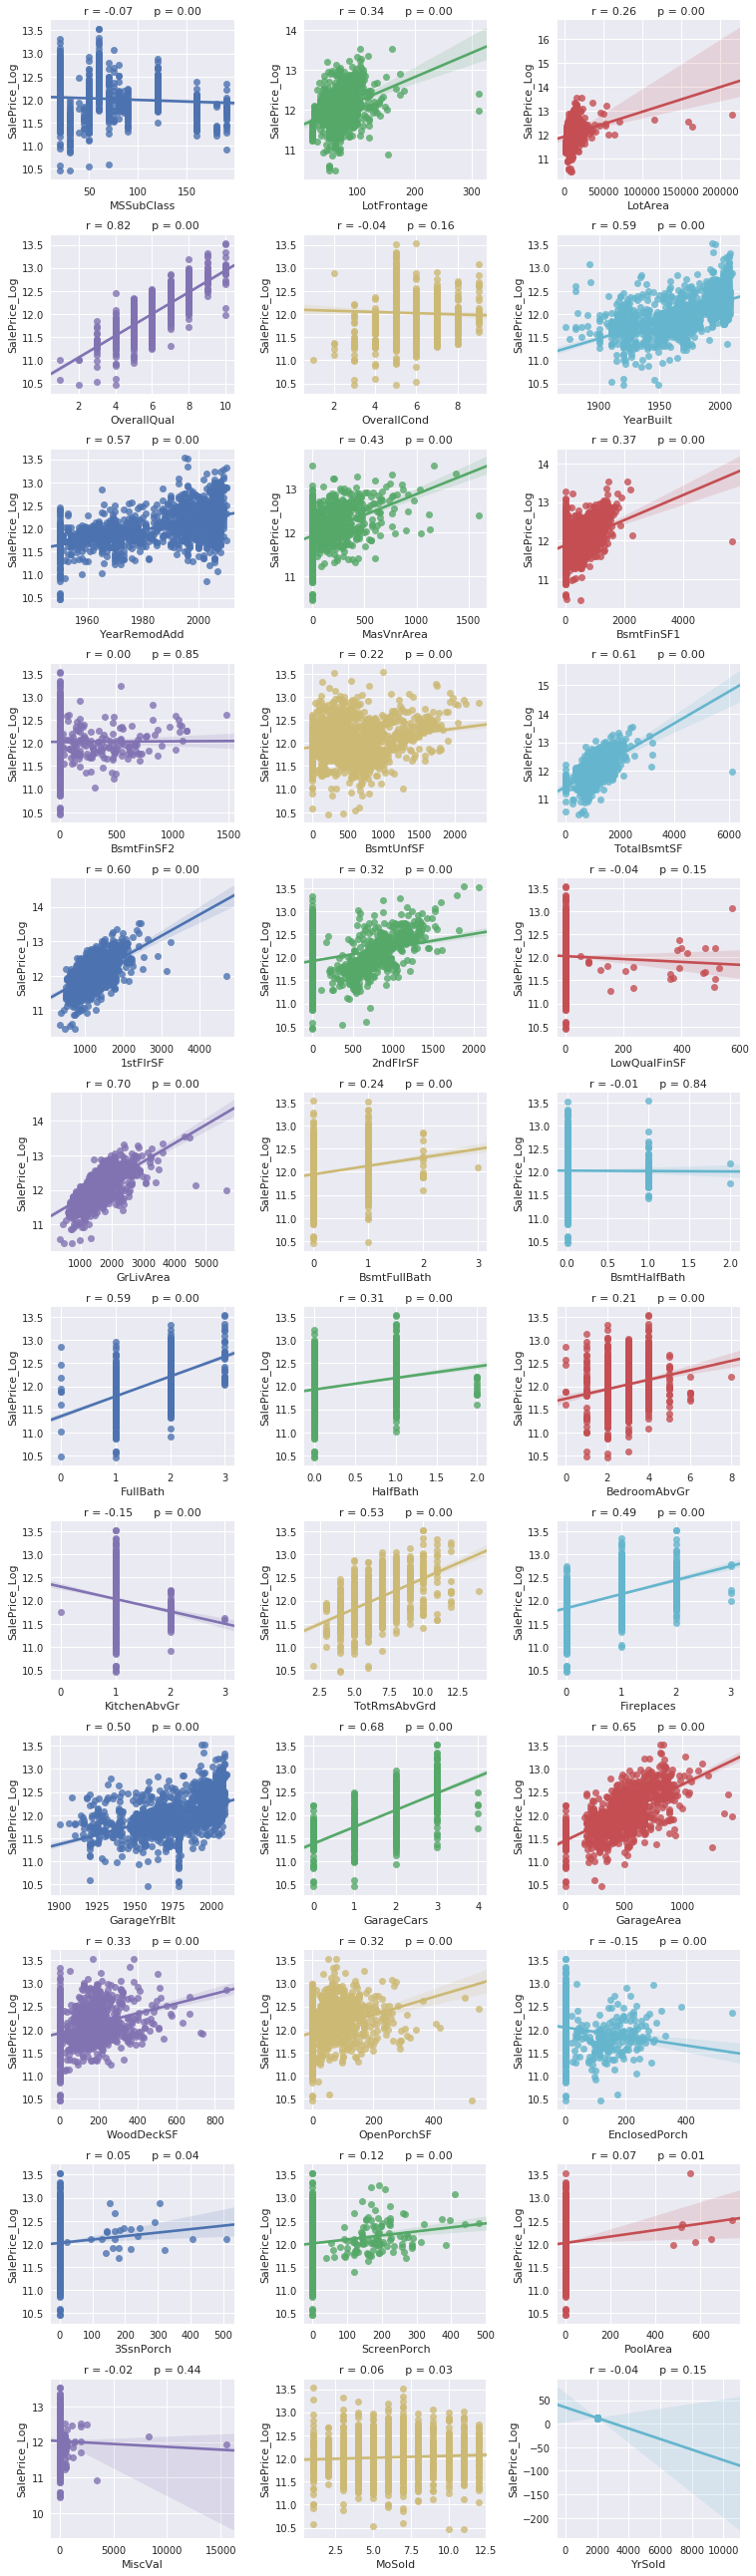

In [26]:
nr_rows = 12
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_num_feats = list(numerical_feats)
li_not_plot = ['Id', 'SalePrice', 'SalePrice_Log']
li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]


for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(train[li_plot_num_feats[i]], train[target], ax = axs[r][c])
            # caculate the regression correlation
            stp = stats.pearsonr(train[li_plot_num_feats[i]], train[target])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


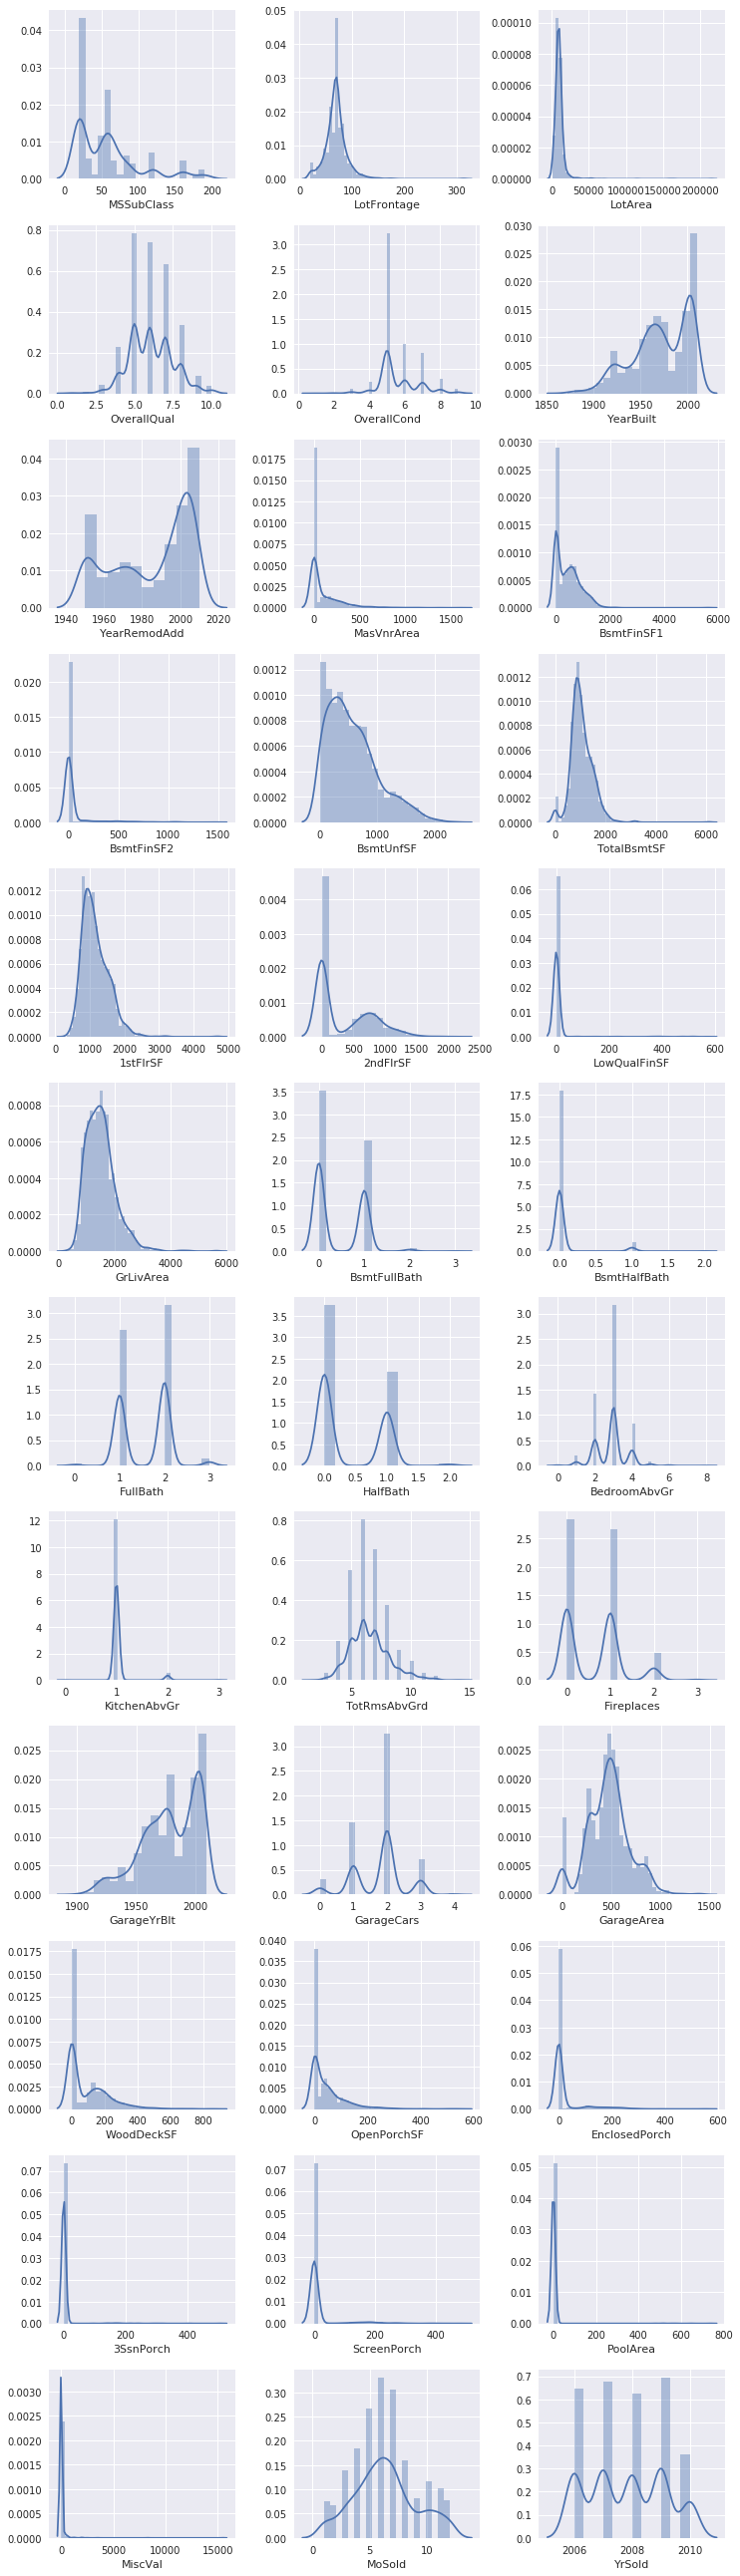

In [27]:
nr_rows = 12
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_num_feats = list(numerical_feats)
li_not_plot = ['Id', 'SalePrice', 'SalePrice_Log']
li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]


for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.distplot(train[li_plot_num_feats[i]], ax = axs[r][c])
            
plt.tight_layout()
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


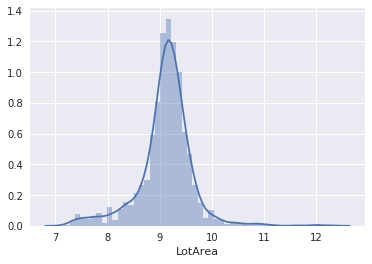

In [28]:
sns.distplot(np.log(train['LotArea']))

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


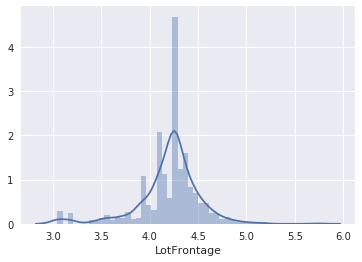

In [29]:
sns.distplot(np.log(train['LotFrontage']))

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


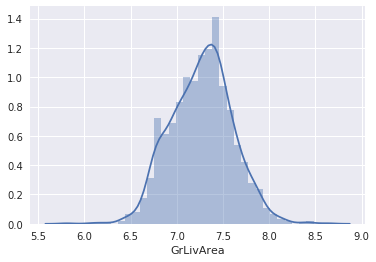

In [30]:
sns.distplot(np.log(train['GrLivArea']))

In [32]:
for df in [train, test]:
    df['GrLivArea'] = np.log(df['GrLivArea'])
    df['LotArea'] = np.log(df['LotArea'])
    df['LotFrontage'] = np.log(df['LotFrontage'])
    

#### Some feature is categorical but described in numerical

In [33]:
corr = train[numerical_feats].corr()['SalePrice_Log'].sort_values(ascending=False)

In [34]:
corr

SalePrice_Log    1.000000
OverallQual      0.817185
GrLivArea        0.730255
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
TotRmsAbvGrd     0.534422
GarageYrBlt      0.500449
Fireplaces       0.489450
MasVnrArea       0.429532
LotArea          0.399918
BsmtFinSF1       0.372023
LotFrontage      0.346178
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209043
ScreenPorch      0.121208
PoolArea         0.069798
MoSold           0.057330
3SsnPorch        0.054900
BsmtFinSF2       0.004832
BsmtHalfBath    -0.005149
Id              -0.017942
MiscVal         -0.020021
OverallCond     -0.036868
YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
EnclosedPorch   -0.149050
Name: SalePr

In [35]:
corr[1:11].index

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
       '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'TotRmsAbvGrd'],
      dtype='object')

In [36]:
for catg in list(categorical_feats) :
    print(train[catg].value_counts())
    print('#'*50)

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
##################################################
Pave    1454
Grvl       6
Name: Street, dtype: int64
##################################################
None    1369
Grvl      50
Pave      41
Name: Alley, dtype: int64
##################################################
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
##################################################
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
##################################################
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
##################################################
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
##################################################
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
###########################

In [37]:
# turn the object into numerical
for catg in list(categorical_feats) :
    x = train[catg].value_counts().index
    for i in range(len(x)):
        train[catg].replace(to_replace = x[i], value = i+1, inplace=True)
        test[catg].replace(to_replace = x[i], value = i+1, inplace=True)
        print(i+1, " replace: ", x[i])
        
    
    print('*'*20)

1  replace:  RL
2  replace:  RM
3  replace:  FV
4  replace:  RH
5  replace:  C (all)
********************
1  replace:  Pave
2  replace:  Grvl
********************
1  replace:  None
2  replace:  Grvl
3  replace:  Pave
********************
1  replace:  Reg
2  replace:  IR1
3  replace:  IR2
4  replace:  IR3
********************
1  replace:  Lvl
2  replace:  Bnk
3  replace:  HLS
4  replace:  Low
********************
1  replace:  AllPub
2  replace:  NoSeWa
********************
1  replace:  Inside
2  replace:  Corner
3  replace:  CulDSac
4  replace:  FR2
5  replace:  FR3
********************
1  replace:  Gtl
2  replace:  Mod
3  replace:  Sev
********************
1  replace:  NAmes
2  replace:  CollgCr
3  replace:  OldTown
4  replace:  Edwards
5  replace:  Somerst
6  replace:  Gilbert
7  replace:  NridgHt
8  replace:  Sawyer
9  replace:  NWAmes
10  replace:  SawyerW
11  replace:  BrkSide
12  replace:  Crawfor
13  replace:  Mitchel
14  replace:  NoRidge
15  replace:  Timber
16  replace:  IDOTR

In [38]:
for catg in list(categorical_feats) :
    print(train[catg].value_counts())
    print('#'*50)

1    1151
2     218
3      65
4      16
5      10
Name: MSZoning, dtype: int64
##################################################
1    1454
2       6
Name: Street, dtype: int64
##################################################
1    1369
2      50
3      41
Name: Alley, dtype: int64
##################################################
1    925
2    484
3     41
4     10
Name: LotShape, dtype: int64
##################################################
1    1311
2      63
3      50
4      36
Name: LandContour, dtype: int64
##################################################
1    1459
2       1
Name: Utilities, dtype: int64
##################################################
1    1052
2     263
3      94
4      47
5       4
Name: LotConfig, dtype: int64
##################################################
1    1382
2      65
3      13
Name: LandSlope, dtype: int64
##################################################
1     225
2     150
3     113
4     100
5      86
6      79
7      77
8      74
9  

In [39]:
corr = (train.corr()['SalePrice_Log']).abs().sort_values(ascending=False)

In [40]:
corr

SalePrice_Log    1.000000
OverallQual      0.817185
GrLivArea        0.730255
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
TotRmsAbvGrd     0.534422
ExterQual        0.523925
GarageYrBlt      0.500449
Foundation       0.493788
Fireplaces       0.489450
MasVnrArea       0.429532
KitchenQual      0.416545
HeatingQC        0.405840
LotArea          0.399918
MasVnrType       0.386202
BsmtFinSF1       0.372023
FireplaceQu      0.357690
CentralAir       0.351599
LotFrontage      0.346178
WoodDeckSF       0.334135
GarageType       0.329777
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
Electrical       0.289857
                   ...   
RoofStyle        0.131424
ScreenPorch      0.121208
BsmtExposure     0.114231
LotConfig        0.105574
BsmtFinType2     0.097603
Neighborhood     0.097321
Alley            0.091145
HouseStyle  

In [41]:
strong_corr = corr.index[:11]

In [42]:
weak_corr = corr.index[11:]

In [43]:
strong_corr

Index(['SalePrice_Log', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd',
       'TotRmsAbvGrd'],
      dtype='object')

In [44]:
weak_corr

Index(['ExterQual', 'GarageYrBlt', 'Foundation', 'Fireplaces', 'MasVnrArea',
       'KitchenQual', 'HeatingQC', 'LotArea', 'MasVnrType', 'BsmtFinSF1',
       'FireplaceQu', 'CentralAir', 'LotFrontage', 'WoodDeckSF', 'GarageType',
       'OpenPorchSF', '2ndFlrSF', 'HalfBath', 'Electrical', 'LotShape',
       'GarageCond', 'PavedDrive', 'GarageFinish', 'BsmtQual', 'BsmtFinType1',
       'MSZoning', 'BsmtFullBath', 'BsmtCond', 'GarageQual', 'BsmtUnfSF',
       'Exterior1st', 'BedroomAbvGr', 'Exterior2nd', 'BldgType', 'ExterCond',
       'Fence', 'Heating', 'EnclosedPorch', 'KitchenAbvGr', 'Functional',
       'RoofStyle', 'ScreenPorch', 'BsmtExposure', 'LotConfig', 'BsmtFinType2',
       'Neighborhood', 'Alley', 'HouseStyle', 'MSSubClass', 'RoofMatl',
       'PoolArea', 'MiscFeature', 'PoolQC', 'SaleType', 'LandContour',
       'Street', 'MoSold', '3SsnPorch', 'SaleCondition', 'LandSlope',
       'LowQualFinSF', 'YrSold', 'OverallCond', 'Condition2', 'Condition1',
       'MiscVal', 'Id', 

## 2.Data Wragling

### Drop Weak Column

In [45]:
for weak_column in weak_corr:
    train.drop(weak_column, inplace = True, axis = 1)
    test.drop(weak_column, inplace = True, axis = 1)

In [46]:
train.shape

(1460, 11)

In [47]:
test.shape

(1459, 10)

#### Features will be used in Regression Model

In [48]:
feats = strong_corr[1:]

In [49]:
feats

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
       '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'TotRmsAbvGrd'],
      dtype='object')

### There is no Missing Data

In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 11 columns):
OverallQual      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
TotalBsmtSF      1460 non-null int64
1stFlrSF         1460 non-null int64
GrLivArea        1460 non-null float64
FullBath         1460 non-null int64
TotRmsAbvGrd     1460 non-null int64
GarageCars       1460 non-null int64
GarageArea       1460 non-null int64
SalePrice_Log    1460 non-null float64
dtypes: float64(2), int64(9)
memory usage: 125.5 KB


In [51]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 10 columns):
OverallQual     1459 non-null int64
YearBuilt       1459 non-null int64
YearRemodAdd    1459 non-null int64
TotalBsmtSF     1459 non-null float64
1stFlrSF        1459 non-null int64
GrLivArea       1459 non-null float64
FullBath        1459 non-null int64
TotRmsAbvGrd    1459 non-null int64
GarageCars      1459 non-null float64
GarageArea      1459 non-null float64
dtypes: float64(4), int64(6)
memory usage: 114.1 KB


### Eliminate outliers by IsolationForest

In [52]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

Number of Outliers: 146
Number of rows without outliers: 1314


In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314 entries, 0 to 1313
Data columns (total 11 columns):
OverallQual      1314 non-null int64
YearBuilt        1314 non-null int64
YearRemodAdd     1314 non-null int64
TotalBsmtSF      1314 non-null int64
1stFlrSF         1314 non-null int64
GrLivArea        1314 non-null float64
FullBath         1314 non-null int64
TotRmsAbvGrd     1314 non-null int64
GarageCars       1314 non-null int64
GarageArea       1314 non-null int64
SalePrice_Log    1314 non-null float64
dtypes: float64(2), int64(9)
memory usage: 113.0 KB


## 3.Model design

### Keras Simple Model

In [54]:
from __future__ import absolute_import, division, print_function

import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.10.0


In [55]:
# Get a validation from sample to test effiency
train_dataset = train
#train_dataset = train.sample(frac=0.85,random_state=0)
#test_dataset = train.drop(train_dataset.index)

In [56]:
#train_dataset.keys()

In [57]:
train_labels = train.pop('SalePrice_Log')

In [58]:
train_stats = train.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
OverallQual,1314.0,6.107306,1.231681,3.000000,5.000000,6.000000,7.000000,10.000000
YearBuilt,1314.0,1973.415525,28.097414,1880.000000,1956.000000,1975.000000,2001.000000,2009.000000
YearRemodAdd,1314.0,1985.258752,20.296170,1950.000000,1968.000000,1994.000000,2004.000000,2010.000000
TotalBsmtSF,1314.0,1043.730594,370.564737,0.000000,806.250000,991.500000,1270.500000,3206.000000
1stFlrSF,1314.0,1137.671994,332.390664,483.000000,882.000000,1078.000000,1358.000000,2259.000000
GrLivArea,1314.0,7.249984,0.296726,6.423247,7.028201,7.273439,7.452402,8.043021
FullBath,1314.0,1.544140,0.522123,0.000000,1.000000,2.000000,2.000000,3.000000
TotRmsAbvGrd,1314.0,6.365297,1.418692,3.000000,5.000000,6.000000,7.000000,12.000000
GarageCars,1314.0,1.807458,0.636708,0.000000,1.000000,2.000000,2.000000,4.000000
GarageArea,1314.0,479.859209,178.050591,0.000000,360.000000,480.000000,576.000000,1069.000000


### Normalize data for training

### This is not improvement
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
train = norm(train)
test = norm(test)

In [87]:
def build_model():
  model = keras.Sequential([
    layers.Dense(60, activation=tf.nn.elu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(30, activation=tf.nn.elu),
    layers.Dense(5, activation=tf.nn.elu),
    layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [88]:
model = build_model()

In [89]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 60)                660       
_________________________________________________________________
dense_7 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 155       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 6         
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [90]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 2000


# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)


history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])


....................................................................................................
....................................................................................................
...................................................................................

loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} Price".format(mae))

test_predictions = model.predict(test_dataset).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [63]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 10 columns):
OverallQual     1459 non-null int64
YearBuilt       1459 non-null int64
YearRemodAdd    1459 non-null int64
TotalBsmtSF     1459 non-null float64
1stFlrSF        1459 non-null int64
GrLivArea       1459 non-null float64
FullBath        1459 non-null int64
TotRmsAbvGrd    1459 non-null int64
GarageCars      1459 non-null float64
GarageArea      1459 non-null float64
dtypes: float64(4), int64(6)
memory usage: 114.1 KB


In [65]:
test.replace('None', 1, inplace = True)

In [ ]:
# test['KitchenQual'].value_counts()

## Predict and submit

In [91]:
test_predictions = model.predict(test).flatten()

In [92]:
test_predictions = np.expm1(test_predictions)

In [93]:
test_predictions

array([164172.39, 144278.28, 173419.84, ..., 185212.56, 130448.42,
       201281.44], dtype=float32)

In [94]:
getid = pd.read_csv('test.csv', usecols = ['Id'])

In [95]:
getid

,Id
0,1461
1,1462
2,1463
3,1464
4,1465
5,1466
6,1467
7,1468
8,1469
9,1470


In [96]:
getid['SalePrice'] = test_predictions

In [97]:
getid.head(10)

,Id,SalePrice
0,1461,164172.390625
1,1462,144278.281250
2,1463,173419.843750
3,1464,174598.250000
4,1465,195843.218750
5,1466,166195.875000
6,1467,185285.343750
7,1468,170685.781250
8,1469,194685.500000
9,1470,147774.437500


In [98]:
getid.to_csv('submit.csv', index = False)